<a href="https://colab.research.google.com/github/JlexZhong/Mineral-classify-by-AI/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 导入相关包


In [34]:
import os
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 定义迁移学习类

In [48]:
class TransferMode:
    """迁移学习类
    """

    def InceptionResNetV2_model(self, lr=0.001, decay=0.0002, momentum=0.9, nb_classes=5, 
                            img_rows=299, img_cols=299, RGB=True, is_plot_model=False):
        """InceptionResNetV2模型，建立自己的模型

        Args:
            lr (float, optional): 学习率. Defaults to 0.005.
            decay ([type], optional): 学习衰减率. Defaults to 1e-6.
            momentum (float, optional): Defaults to 0.9.
            nb_classes (int, optional): 分类数. Defaults to 2.
            img_rows (int, optional): 图片行数. Defaults to 197.
            img_cols (int, optional): 图片列数. Defaults to 197.
            RGB (bool, optional): 是否为3通道图片. Defaults to True.
            is_plot_model (bool, optional): 是否画出模型网络结构图. Defaults to False.

        Returns:
            [type]: 返回模型
        """
        color = 3 if RGB else 1
        # 假设最后一层CNN的层输出为(img_rows, img_cols, color)
        print('=================加载预训练模型=================')
        base_model = InceptionResNetV2(weights='imagenet',
                                 include_top=False,
                                 input_shape=(img_rows, img_cols, color),
                                 )
        # 对我们的输出进行平铺操作,為全連接层做准备
        x = layers.Flatten()(base_model.output)
        # 增加一个全连接层，并使用relu作为激活函数，这是需要训练的
        x = layers.Dense(1024, activation='relu')(x)  # l2正则化 relu激活函数
        # 添加随机失活，抑制过拟合
        x = layers.Dropout(0.4)(x)
        # ，输出层，把输出设置成softmax函数
        predictions = layers.Dense(nb_classes, activation='softmax')(x)  # ! 不能正则化
        # 训练模型
        print('================创建自己的模型==================')
        model = Model(inputs=base_model.input, outputs=predictions)
        # 冻结base_model所有层，这样就可以正确获得bottleneck特征
        for layer in base_model.layers:
            layer.trainable = False
        sgd = SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
        print('================编译模型=================')
        
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # BUG：交叉熵损失函数
                      optimizer=sgd,  #tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
                      metrics=['accuracy'])
        print('=================打印模型结构信息=================')
        model.summary()
        # 可视化网络结构，生成图片
        if is_plot_model:
            plot_model(model, to_file='inceptionV3_model.png',
                       show_shapes=True)
        return model


    def DataGen(self, dir_path, img_row, img_col, batch_size, is_train):
        """读取数据集，并进行数据增强和打标签

        Args:
            dir_path (str)): 数据集路径
            img_row (int): 行数
            img_col (int): 行数
            batch_size (int): 批数量
            is_train (bool): 是否为训练集

        Returns:
            [type]: 数据集
        """
        if is_train:
            # ImageDataGenerator :生产图片的批次张量值并且提供数据增强功能
            print('==================读取训练数据================')
            datagen = ImageDataGenerator(              rescale=1. / 255,
                                         zoom_range=0.7,      # 缩放强度
                                         rotation_range=45.,    # 图片旋转的角度范围
                                         width_shift_range=0.5,  # 图片随机水平偏移的幅度
                                         height_shift_range=0.5,  # 图片随机垂直偏移的幅度
                                         horizontal_flip=True,   #随机水平翻转
                                         vertical_flip = True,
                                         shear_range=0.7,
                                         fill_mode='nearest')  # fill_mode：‘constant’，‘nearest’，‘reflect’或‘wrap’之一，
                                                                # 当进行变换时超出边界的点将根据本参数给定的方法进行处理
        else:
            # 验证集不需要数据增强
            print('==================读取验证数据================')
            datagen = ImageDataGenerator(rescale=1. / 255)
        generator = datagen.flow_from_directory(
                                        dir_path,  # 数据存放路径
                                        target_size=(img_row, img_col),  # 目标形状
                                        batch_size=batch_size,  # 批数量大小
                                        class_mode='categorical',  # 二分类使用binary
                                        # "categorical" ：2D one-hot encoded labels
                                        # "binary" will be 1D binary labels
                                        shuffle=is_train  # 是否打乱
                                            )
        return generator
    

    def ResNet152V2_model(self, lr=0.005, decay=1e-6, momentum=0.9, nb_classes=10, img_rows=224, img_cols=224, RGB=True, is_plot_model=False):
        """ResNet50神经网络模型

        Args:
            lr (float, optional): [description]. Defaults to 0.0001.
            decay ([type], optional): [description]. Defaults to 1e-6.
            momentum (float, optional): [description]. Defaults to 0.9.
            nb_classes (int, optional): [description]. Defaults to 2.
            img_rows (int, optional): [description]. Defaults to 197.
            img_cols (int, optional): [description]. Defaults to 197.
            RGB (bool, optional): [description]. Defaults to True.
            is_plot_model (bool, optional): [description]. Defaults to False.

        Returns:
            [type]: [description]
        """
        color = 3 if RGB else 1
        base_model = ResNet152V2(weights='imagenet', 
                            include_top=False, 
                            pooling=None, 
                            input_shape=(img_rows, img_cols, color)
                            )
 
        #冻结base_model所有层，这样就可以正确获得bottleneck特征
        for layer in base_model.layers:
            layer.trainable = False
 
        x = base_model.output
        #添加自己的全链接分类层
        
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(1024, activation='relu')(x)
        predictions = layers.Dense(nb_classes, activation='softmax')(x)
 
        #训练模型
        model = Model(inputs=base_model.input, outputs=predictions)
        sgd = SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.summary()
        #绘制模型
        if is_plot_model:
            plot_model(model, to_file='resnet50_model.png',show_shapes=True)
 
        return model

    # InceptionV3模型
    def InceptionV3_model(self, lr=0.00001, decay=1e-6, momentum=0.9, nb_classes=2, 
                            img_rows=197, img_cols=197, RGB=True, is_plot_model=False):
        """InceptionV3模型，建立自己的模型

        Args:
            lr (float, optional): 学习率. Defaults to 0.005.
            decay ([type], optional): 学习衰减率. Defaults to 1e-6.
            momentum (float, optional): Defaults to 0.9.
            nb_classes (int, optional): 分类数. Defaults to 2.
            img_rows (int, optional): 图片行数. Defaults to 197.
            img_cols (int, optional): 图片列数. Defaults to 197.
            RGB (bool, optional): 是否为3通道图片. Defaults to True.
            is_plot_model (bool, optional): 是否画出模型网络结构图. Defaults to False.

        Returns:
            [type]: 返回模型
        """
        color = 3 if RGB else 1
        # 假设最后一层CNN的层输出为(img_rows, img_cols, color)
        print('=================加载预训练模型=================')
        base_model = InceptionV3(weights='imagenet',
                                 include_top=False,
                                 input_shape=(img_rows, img_cols, color),
                                 )
        # 对我们的输出进行平铺操作,為全連接层做准备
        x = layers.Flatten()(base_model.output)
        # 增加一个全连接层，并使用relu作为激活函数，这是需要训练的
        x = layers.Dense(1024, activation='relu')(x)  # l2正则化 relu激活函数
        # 添加随机失活，抑制过拟合
        x = layers.Dropout(0.4)(x)
        # ，输出层，把输出设置成softmax函数
        predictions = layers.Dense(nb_classes, activation='softmax')(x)  # ! 不能正则化
        # 训练模型
        print('================创建自己的模型==================')
        model = Model(inputs=base_model.input, outputs=predictions)
        # 冻结base_model所有层，这样就可以正确获得bottleneck特征
        for layer in base_model.layers:
            layer.trainable = False
        sgd = SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
        print('================编译模型=================')
        
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # BUG：交叉熵损失函数
                      optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
                      metrics=['accuracy'])
        print('=================打印模型结构信息=================')
        model.summary()
        # 可视化网络结构，生成图片
        if is_plot_model:
            plot_model(model, to_file='inceptionV3_model.png',
                       show_shapes=True)
        return model

    def train_model(self, model, epochs, train_generator, steps_per_epoch, 
                    validation_generator, validation_steps,path_save_model, is_load_model=False):
        """训练模型，载入、保存、断点续训

        Args:
            model ([type]): 模型
            epochs ([type]): 训练次数
            train_generator ([type]): 训练集
            steps_per_epoch ([type]): 
            validation_generator ([type]): 验证集
            validation_steps ([type]): 
            path_save_model ([type]): 保存模型路径
            is_load_model (bool, optional): 是否载入模型. Defaults to False.

        Returns:
            [type]: 训练记录
        """
        # 载入模型
        if is_load_model and os.path.exists(path_save_model):
            print('================载入已训练模型===============')
            model = load_model(path_save_model)
        # 使用tensorboard
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir)
        # 断点续训
        # 格式化字符，防止文件名冲突
        checkpoint_path = 'ckpt/widgets_{epoch:02d}-{accuracy:.2f}.h5'
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                checkpoint_path,  # 保存路径，指定为tensorflow二进制文件ckpt
                                monitor='accuracy',  # 监测指标，这里是测试集的acc
                                save_best_only=True,  # 是否只保存最佳
                                save_weights_only=True,  # 只保存权重
                                mode='max',
                                period=2  # 每period个周期保存一次
        )
        # 动态更改学习率
        reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau()
        

        # 训练
        print('================开始训练================')
        history_ft = model.fit_generator(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            verbose=1,  # 日志显示，0/1,1表示输出进度条日志信息
            callbacks=[tensorboard_callback, checkpoint_callback,reduce_lr])
        # 模型保存
        print('================保存模型================')
        model.save(path_save_model, overwrite=True)
        return history_ft

    def plot_training(self, history,epochs):
        """可视化acc/loss图

        Args:
            history ([type]): 训练
            epochs: 迭代次数
        """
        print('================绘制acc/loss图================')
        # 记录训练集和验证集的准确率和损失值
        history_dict = history.history
        train_loss = history_dict["loss"] #训练集损失值
        train_accuracy = history_dict["accuracy"] #训练集准确率
        val_loss = history_dict["val_loss"] #验证集损失值
        val_accuracy = history_dict["val_accuracy"] #验证集准确率
        plt.figure()
        plt.plot(range(epochs), train_loss, label='train_loss')
        plt.plot(range(epochs), val_loss, label='val_loss')
        plt.legend()
        
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.savefig('./result/resnet_loss.png')
        plt.figure()
        plt.plot(range(epochs), train_accuracy, label='train_accuracy')
        plt.plot(range(epochs), val_accuracy, label='val_accuracy')
        plt.legend()
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.savefig('./result/resnet_acc.png')
        plt.show()


# 进入工作目录

In [44]:
cd /content/drive/MyDrive/Transfer_learning

/content/drive/MyDrive/Transfer_learning


# 定义基本参数

In [37]:
image_size = 224
batch_size = 32
num_train = 4317
num_val = 807
epochs = 20

# 构建基本模型

In [49]:
transfer_model = TransferMode()

# 数据预处理

In [50]:
train_generator = transfer_model.DataGen('./data/new_paddle_mineral_data/train',
                                             image_size,
                                             image_size,
                                             batch_size,
                                             True)
validation_generator = transfer_model.DataGen('./data/new_paddle_mineral_data/val',
                                            image_size,
                                            image_size,
                                            batch_size,
                                            True)

==================读取训练数据================
Found 4317 images belonging to 10 classes.
==================读取训练数据================
Found 807 images belonging to 10 classes.


# 构建深度神经网络模型

In [51]:
model = transfer_model.ResNet152V2_model(nb_classes=10,
                      img_rows=image_size,
                      img_cols=image_size,
                      is_plot_model=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

**训练**

In [56]:
history_ft = transfer_model.train_model(model,
                    epochs=epochs,
                    train_generator=train_generator,
                    steps_per_epoch=num_train / batch_size,
                    validation_generator=validation_generator,
                    validation_steps=num_val / batch_size,
                    path_save_model='model/data_scidb_model_ResNet152V2.h5',
                    is_load_model=False)

================开始训练================


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
134/134 [==============================] - 1478s 11s/step - loss: 0.5600 - accuracy: 0.8140 - val_loss: 0.2714 - val_accuracy: 0.9157
Epoch 2/20
134/134 [==============================] - 87s 648ms/step - loss: 0.2345 - accuracy: 0.9240 - val_loss: 0.2530 - val_accuracy: 0.9232
Epoch 3/20
134/134 [==============================] - 89s 661ms/step - loss: 0.2225 - accuracy: 0.9233 - val_loss: 0.2075 - val_accuracy: 0.9356
Epoch 4/20
134/134 [==============================] - 88s 649ms/step - loss: 0.2079 - accuracy: 0.9263 - val_loss: 0.2203 - val_accuracy: 0.9219
Epoch 5/20
134/134 [==============================] - 87s 646ms/step - loss: 0.1821 - accuracy: 0.9395 - val_loss: 0.1777 - val_accuracy: 0.9393
Epoch 6/20
134/134 [==============================] - 86s 640ms/step - loss: 0.1777 - accuracy: 0.9384 - val_loss: 0.1681 - val_accuracy: 0.9356
Epoch 7/20
134/134 [==============================] - 87s 645ms/step - loss: 0.1606 - accuracy: 0.9497 - val_loss: 0.1405 - val_ac

# 绘制acc-loss图

================绘制acc/loss图================


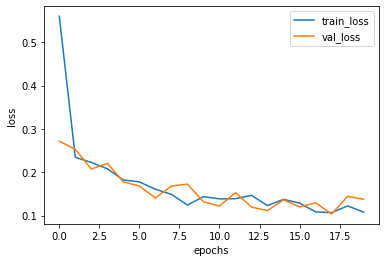

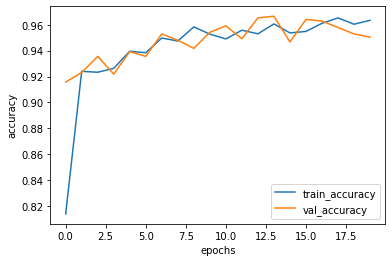

In [57]:
transfer_model.plot_training(history_ft,epochs)

# 预测

In [58]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [60]:
test_path = './data/new_paddle_mineral_data/test'

In [62]:
test_generator = test_datagen.flow_from_directory(
                      test_path,  # 数据存放路径
                      target_size=(image_size, image_size),  # 目标形状
                      batch_size=batch_size,  # 批数量大小
                      class_mode='categorical',  # 二分类使用binary
                      # "categorical" ：2D one-hot encoded labels
                      # "binary" will be 1D binary labels
                      shuffle=False  # 是否打乱
                  )

Found 264 images belonging to 10 classes.


In [63]:
loss ,accuracy = model.evaluate(test_generator)
print('model test loss :', loss)
print('model test accuracy :', accuracy)

9/9 [==============================] - 65s 8s/step - loss: 0.0142 - accuracy: 0.9962
model test loss : 0.014247586019337177
model test accuracy : 0.9962121248245239
